# Group Knockoffs

This tutorial generates group (model-X) knockoffs, which is useful when predictors are highly correlated. The methodology is described in the following paper

> Dai R, Barber R. The knockoff filter for FDR control in group-sparse and multitask regression. InInternational conference on machine learning 2016 Jun 11 (pp. 1851-1859). PMLR.


!!! note

    In the original paper, Dai and Barber only describes how to construct a suboptimal equi-correlated group knockoffs. Here we implement fully generalized alternatives.
    
Currently available options for group knockoffs:
+ `:mvr`: Fully general minimum variance-based reconstructability (MVR) group knockoff, based on coordinate descent.
+ `:maxent`: Fully general maximum entropy (maxent) group knockoff, based on coordinate descent.
+ `:equi`: This implements the equi-correlated idea proposed in [Barber and Dai](https://proceedings.mlr.press/v48/daia16.html), which lets $S_j = \gamma \Sigma_{(G_j, G_j)}$ where $\Sigma_{(G_j, G_j)}$ is the block of $\Sigma$ containing variables in the $j$th group. Thus, instead of optimizing over all variables in $S$, we optimize a scalar $\gamma$. Conveniently, there a simple closed form solution for $\gamma$. For `mvr` and `maxent` group knockoffs, we initialize $S$ using this construction. 
+ `:SDP`: This generalizes the equi-correlated group knockoff idea by having $S_j = \gamma_j \Sigma_{(G_j, G_j)}$. Instead of optimizing over all variables in $S$, we optimize over a vector $\gamma_1,...,\gamma_G$. 


In [1]:
# load packages for this tutorial
using Revise
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using Clustering
using ProgressMeter
using Plots
gr(fmt=:png);

# some helper functions to compute power and empirical FDR
function TP(correct_groups, signif_groups)
    return length(signif_groups ∩ correct_groups) / length(correct_groups)
end
function TP(correct_groups, β̂, groups)
    signif_groups = get_signif_groups(β̂, groups)
    return TP(correct_groups, signif_groups)
end
function FDR(correct_groups, signif_groups)
    FP = length(signif_groups) - length(signif_groups ∩ correct_groups) # number of false positives
    FDR = FP / max(1, length(signif_groups))
    return FDR
end
function FDR(correct_groups, β̂, groups)
    signif_groups = get_signif_groups(β̂, groups)
    return FDR(correct_groups, signif_groups)
end
function get_signif_groups(β, groups)
    correct_groups = Int[]
    for i in findall(!iszero, β)
        g = groups[i]
        g ∈ correct_groups || push!(correct_groups, g)
    end
    return correct_groups
end

┌ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]
└ @ Base loading.jl:1423


get_signif_groups (generic function with 1 method)

# Constructing group knockoffs

First, let's simulate data and generate equi-correlated knockoffs. Our true covariance matrix looks like

```math
\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}, \quad \rho = 0.9
\end{aligned}
```

Because variables are highly correlated with its neighbors ($\rho = 0.9$), it becomes difficult to distinguish which variables among a group are truly causal. Thus, group knockoffs which test whether a *group* of variables have any signal should have better power than standard (single-variable) knockoffs. 

For simplicity, let simulate data where every 5 variables form a group:

In [5]:
# simulate data
Random.seed!(2022)
n = 1000 # sample size
p = 200  # number of covariates
k = 10   # number of true predictors
Σ = Matrix(SymmetricToeplitz(0.4.^(0:(p-1)))) # true covariance matrix
groupsizes = [5 for i in 1:div(p, 5)] # each group has 5 variables
groups = vcat([i*ones(g) for (i, g) in enumerate(groupsizes)]...) |> Vector{Int}
true_mu = zeros(p)
L = cholesky(Σ).L
X = randn(n, p) * L
zscore!(X, mean(X, dims=1), std(X, dims=1)); # standardize columns of X

Generate group knockoffs with the exported function `modelX_gaussian_group_knockoffs`. Similar to non-group knockoffs, group knockoff accepts keyword arguments `m`, `tol`, `niter`, and `verbose` which controls the algorithm's behavior. 

In [19]:
Gmvr = modelX_gaussian_group_knockoffs(
    X, :mvr, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.0001,   # convergence tolerance
    niter = 100,    # max number of coordinate descent iterations
    backtrack=true,
    verbose=true);  # whether to print informative intermediate results

initial obj = 660.7492586895438
Iter 1: obj = 580.3014802334117, δ = 0.40849450737307075, t1 = 6.47, t2 = 0.05, t3 = 0.0
Iter 2: obj = 576.356903530901, δ = 0.040317674773475906, t1 = 12.65, t2 = 0.1, t3 = 0.0
Iter 3: obj = 575.8655116237313, δ = 0.01780874829412893, t1 = 18.81, t2 = 0.15, t3 = 0.0
Iter 4: obj = 575.6847264917337, δ = 0.01184723583970696, t1 = 25.58, t2 = 0.21, t3 = 0.0
Iter 5: obj = 575.6264790875264, δ = 0.004771160733640403, t1 = 32.3, t2 = 0.26, t3 = 0.01
Iter 6: obj = 575.6057942714749, δ = 0.0038896196229028512, t1 = 38.49, t2 = 0.31, t3 = 0.01
Iter 7: obj = 575.5963286258791, δ = 0.0023969650797290216, t1 = 44.8, t2 = 0.36, t3 = 0.01
Iter 8: obj = 575.5917621998456, δ = 0.0018504942583568813, t1 = 51.16, t2 = 0.41, t3 = 0.01
Iter 9: obj = 575.589426931424, δ = 0.0013961245469877668, t1 = 57.91, t2 = 0.47, t3 = 0.01
Iter 10: obj = 575.5882103068211, δ = 0.001014112733149566, t1 = 64.37, t2 = 0.52, t3 = 0.01
Iter 11: obj = 575.5875998351219, δ = 0.0007910103470764

In [31]:
Gme = modelX_gaussian_group_knockoffs(
    X, :maxent, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.0001,   # convergence tolerance
    niter = 100,    # max number of coordinate descent iterations
    backtrack=true,
    verbose=true);  # whether to print informative intermediate results

initial obj = -95.65651939765823
Iter 1: obj = -83.11676608095186, δ = 0.3588024075628171, t1 = 0.02, t2 = 0.02, t3 = 0.0
Iter 2: obj = -82.83090154353826, δ = 0.03510704191353789, t1 = 0.03, t2 = 0.04, t3 = 0.0
Iter 3: obj = -82.77409948536202, δ = 0.011098803370812009, t1 = 0.04, t2 = 0.05, t3 = 0.0
Iter 4: obj = -82.760141210536, δ = 0.005297873277053722, t1 = 0.04, t2 = 0.06, t3 = 0.0
Iter 5: obj = -82.7562748582411, δ = 0.0027180401372862723, t1 = 0.05, t2 = 0.07, t3 = 0.0
Iter 6: obj = -82.75515128811799, δ = 0.0017248174876503754, t1 = 0.06, t2 = 0.08, t3 = 0.0
Iter 7: obj = -82.75480847888738, δ = 0.001078500284056402, t1 = 0.07, t2 = 0.1, t3 = 0.0
Iter 8: obj = -82.75470438899146, δ = 0.0005949198887282596, t1 = 0.08, t2 = 0.11, t3 = 0.0
Iter 9: obj = -82.75467471827024, δ = 0.00031766452779075267, t1 = 0.09, t2 = 0.12, t3 = 0.0
Iter 10: obj = -82.75466679123363, δ = 0.0001742210740395128, t1 = 0.1, t2 = 0.13, t3 = 0.0
Iter 11: obj = -82.75466469993464, δ = 9.158461447381083e-

In [33]:
@time Gsdp = modelX_gaussian_group_knockoffs(
    X, :sdp, groups, true_mu, Σ, 
    m = 1,          # number of knockoffs per variable to generate
    tol = 0.0001,   # convergence tolerance
    niter = 100,    # max number of coordinate descent iterations
    backtrack=false,
    verbose=true);  # whether to print informative intermediate results

  1.393058 seconds (237.81 k allocations: 68.251 MiB)


In [34]:
Gsdp.S

200×200 Matrix{Float64}:
 1.0     0.4    0.16  0.064  0.0256  …  0.0     0.0    0.0   0.0    0.0
 0.4     1.0    0.4   0.16   0.064      0.0     0.0    0.0   0.0    0.0
 0.16    0.4    1.0   0.4    0.16       0.0     0.0    0.0   0.0    0.0
 0.064   0.16   0.4   1.0    0.4        0.0     0.0    0.0   0.0    0.0
 0.0256  0.064  0.16  0.4    1.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0     …  0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0     …  0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 0.0     0.0    0.0   0.0    0.0        0.0     0.0    0.0   0.0    0.0
 ⋮                                   ⋱ 

In [32]:
Gme.S

200×200 Matrix{Float64}:
 1.0        0.400036   0.16006   0.063989  …  0.0       0.0        0.0
 0.400036   1.0        0.400015  0.160007     0.0       0.0        0.0
 0.16006    0.400015   1.0       0.400011     0.0       0.0        0.0
 0.063989   0.160007   0.400011  1.0          0.0       0.0        0.0
 0.0174266  0.0435755  0.108935  0.272328     0.0       0.0        0.0
 0.0        0.0        0.0       0.0       …  0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0       …  0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 ⋮                                         ⋱        

In [28]:
Gmvr.S

200×200 Matrix{Float64}:
 1.0        0.400026   0.160089  0.065872  …  0.0       0.0        0.0
 0.400026   1.0        0.399987  0.163929     0.0       0.0        0.0
 0.160089   0.399987   1.0       0.406519     0.0       0.0        0.0
 0.065872   0.163929   0.406519  1.0          0.0       0.0        0.0
 0.0168259  0.0417786  0.103529  0.25684      0.0       0.0        0.0
 0.0        0.0        0.0       0.0       …  0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0       …  0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 0.0        0.0        0.0       0.0          0.0       0.0        0.0
 ⋮                                         ⋱        

In [35]:
sum(Gmvr.S), sum(Gme.S), sum(Gsdp.S)

(321.9197151712727, 322.53606225743187, 378.688)

Note $t_1, t_2, t_3$ are timers which corresponds to (1) updating cholesky factors, (2) solving forward-backward equations, and (3) solving off-diagonal 1D optimization problems using Brent's method. As we can see, the computational bottleneck in (2), which we dispatch to efficient LAPACK libraries. 

The output is a struct with the following fields
```julia
struct GaussianGroupKnockoff{T<:AbstractFloat, BD<:AbstractMatrix, S<:Symmetric} <: Knockoff
    X::Matrix{T} # n × p design matrix
    X̃::Matrix{T} # n × p knockoff of X
    groups::Vector{Int} # p × 1 vector of group membership
    S::BD # p × p block-diagonal matrix of the same size as Σ. S and 2Σ - S are both psd
    γs::Vector{T} # scalars chosen so that 2Σ - S is positive definite where S_i = γ_i * Σ_i
    Σ::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
end
```
Given this result, lets do a sanity check: is $2\Sigma - S$ positive semi-definite?

In [4]:
# compute minimum eigenvalues of 2Σ - S
eigmin(2Gme.Σ - Gme.S)

0.417481414774321

## Second order group knockoffs

In practice, we often do not have the true covariance matrix $\Sigma$ and the true means $\mu$. In that case, we can generate second order group knockoffs via the 3 argument function

In [5]:
Gme_second_order = modelX_gaussian_group_knockoffs(X, :maxent, groups);

This will estimate the covariance matrix via a shrinkage estimator, see documentation API for more details. 

## Lasso Example

Lets repeat the simulation in Fig 9 of [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short).  

In [45]:
distmat = 1 .- cor(X)
result = hclust(distmat; linkage=:single)

Hclust{Float64}([-96 -97; -24 -25; … ; 455 496; 497 498], [0.0970064165687714, 0.1012060795718639, 0.1014793589729247, 0.10266441618966671, 0.10305172655360806, 0.10798689401517203, 0.10905712165670112, 0.10971816499739906, 0.11090883223570303, 0.11797787856740127  …  0.6551004597475145, 0.6789130247900996, 0.6913206285397023, 0.7028417864831533, 0.7232399398389482, 0.7484541597148502, 0.7633104625456545, 0.8042074778272674, 0.8090412980919948, 0.8607792995901705], [453, 450, 451, 452, 500, 489, 495, 492, 490, 491  …  119, 124, 123, 121, 122, 113, 114, 115, 116, 117], :single)

In [51]:
cutree(result, h=0.3)

500-element Vector{Int64}:
   1
   2
   2
   3
   3
   4
   4
   5
   6
   7
   8
   9
   9
   ⋮
 142
 143
 143
 143
 143
 143
 144
 145
 145
 145
 146
 147

In [66]:
target_fdr = 0.1
m = 1
p = 500
k = 50
n = 250 # sample size
nsims = 10
c_corrs = 0.7:0.1:1 # between 1 (ungrouped) and 0.7 (~3 variable per group)

sdp_power, sdp_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
mvr_power, mvr_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))
me_power, me_fdr = zeros(length(c_corrs)), zeros(length(c_corrs))

pmeter = Progress(nsims*length(c_corrs))
for sim in 1:nsims, (idx, c_corr) in enumerate(c_corrs)
    # simulate AR1 Σ
    Σ = simulate_AR1(p, a=3, b=1)

    # simulate X
    Random.seed!(sim)
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1))

    # single-linkage heirarchical clustering to define groups
    distmat = 1 .- cor(X)
    cluster_result = hclust(distmat; linkage=:single)
    groups = cutree(result, h=1-c_corr)

    # simulate y
    δ = 2
    βtrue = zeros(p)
    βtrue[1:k] .= rand(-1:2:1, k) .* rand(Uniform(δ/2, δ), k)
    shuffle!(βtrue)
    ϵ = randn(n)
    y = X * βtrue + ϵ;

    # find truly causal groups
    correct_groups = get_signif_groups(βtrue, groups)

    # sdp
    t = @elapsed ko_filter = fit_lasso(y, X, method=:sdp, groups=groups, m=m)
    fdr_idx = findfirst(x -> x == target_fdr, ko_filter.fdr_target)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    sdp_power[idx] += power
    sdp_fdr[idx] += fdr
    
    # mvr
    t = @elapsed ko_filter = fit_lasso(y, X, method=:mvr, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    mvr_power[idx] += power
    mvr_fdr[idx] += fdr
    
    # me
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent, groups=groups, m=m)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    me_power[idx] += power
    me_fdr[idx] += fdr
    
    next!(pmeter)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:46:04


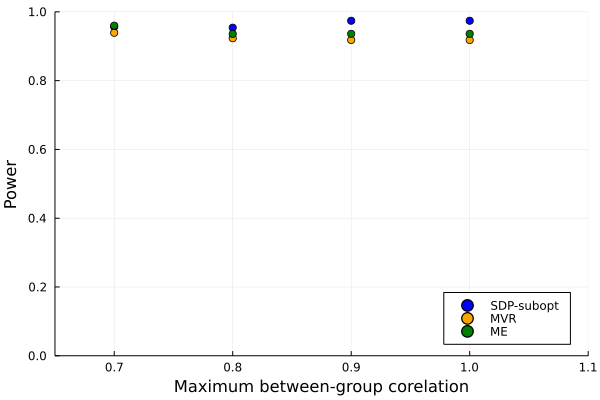

In [77]:
power_plt = plot(; xlim=(0.65, 1.1), xlabel="Maximum between-group corelation", ylim=(0, 1), 
    ylabel="Power", legend=:bottomright)
scatter!(power_plt, c_corrs, sdp_power ./ nsims, label="SDP-subopt", color="blue")
scatter!(power_plt, c_corrs, mvr_power ./ nsims, label="MVR", color="orange")
scatter!(power_plt, c_corrs, me_power ./ nsims, label="ME", color="green")

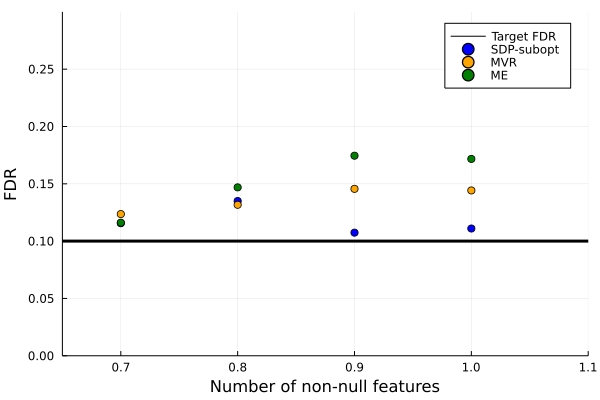

In [79]:
fdr_plt = plot(; xlim=(0.65, 1.1), xlabel="Number of non-null features", ylim=(0, 0.3), ylabel="FDR")
hline!(fdr_plt, [target_fdr], label="Target FDR", w=3, color="black")
scatter!(fdr_plt, c_corrs, sdp_fdr ./ nsims, label="SDP-subopt", color="blue")
scatter!(fdr_plt, c_corrs, mvr_fdr ./ nsims, label="MVR", color="orange")
scatter!(fdr_plt, c_corrs, me_fdr ./ nsims, label="ME", color="green")

## Lasso Example

see the empirical power and FDR group knockoffs over 10 simulations when the targer FDR is 10%. Here power and FDR is defined at the group level. 

In [49]:
target_fdr = 0.1
group_powers, group_fdrs, group_times, group_s = Float64[], Float64[], Float64[], Float64[]

Random.seed!(2022)
for sim in 1:10
    # simulate X
    Random.seed!(sim)
    n = 1000 # sample size
    p = 200  # number of covariates
    k = 10   # number of true predictors
    Σ = Matrix(SymmetricToeplitz(0.9.^(0:(p-1)))) # true covariance matrix
    groupsizes = [5 for i in 1:div(p, 5)] # each group has 5 variables
    groups = vcat([i*ones(g) for (i, g) in enumerate(groupsizes)]...) |> Vector{Int}
    true_mu = zeros(p)
    L = cholesky(Σ).L
    X = randn(n, p) * L
    zscore!(X, mean(X, dims=1), std(X, dims=1)); # standardize columns of X

    # simulate y
    βtrue = zeros(p)
    βtrue[1:k] .= rand(-1:2:1, k) .* 0.1
    shuffle!(βtrue)
    correct_groups = get_signif_groups(βtrue, groups)
    ϵ = randn(n)
    y = X * βtrue + ϵ;

    # group MVR knockoffs
    t = @elapsed ko_filter = fit_lasso(y, X, method=:maxent, groups=groups)
    fdr_idx = findfirst(x -> x == target_fdr, ko_filter.fdr_target)
    power = round(TP(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    fdr = round(FDR(correct_groups, ko_filter.βs[fdr_idx], groups), digits=3)
    println("Sim $sim group-knockoff power = $power, FDR = $fdr, time=$t")
    push!(group_powers, power); push!(group_fdrs, fdr); push!(group_times, t)
    GC.gc();GC.gc();GC.gc();
end

println("\nME group knockoffs have average group power $(mean(group_powers))")
println("ME group knockoffs have average group FDR $(mean(group_fdrs))")
println("ME group knockoffs took average $(mean(group_times)) seconds");

Sim 1 group-knockoff power = 0.0, FDR = 0.0, time=5.356796708
Sim 2 group-knockoff power = 0.1, FDR = 0.0, time=3.846174709
Sim 3 group-knockoff power = 0.222, FDR = 0.0, time=2.418540375
Sim 4 group-knockoff power = 0.4, FDR = 0.2, time=3.774003875
Sim 5 group-knockoff power = 0.4, FDR = 0.0, time=2.337522042
Sim 6 group-knockoff power = 0.0, FDR = 0.0, time=3.913260458
Sim 7 group-knockoff power = 0.222, FDR = 0.333, time=2.531130667
Sim 8 group-knockoff power = 0.0, FDR = 0.0, time=3.927257125
Sim 9 group-knockoff power = 0.0, FDR = 0.0, time=3.9803245
Sim 10 group-knockoff power = 0.1, FDR = 0.0, time=2.300255291

ME group knockoffs have average group power 0.1444
ME group knockoffs have average group FDR 0.0533
ME group knockoffs took average 3.438526575 seconds


## Conclusion

+ When variables are highly correlated so that one cannot find exact discoveries, group knockoffs may be useful as it identifies whether a group of variables are non-null without having to pinpoint the exact discovery.
+ Group knockoffs control the group FDR to be below the target FDR level. 
+ Groups do not have to be contiguous
